# Проект
Проект по обработке аудиофайлов колл-центра Trade Desk. В проекте ставилось несколько задач:
- Первод аудио в текст
- Разделение аудио по участникам, определение пола и возрастной группы участников диалога

Структура данных проекта:
```
./__pycache__       # рус файлы
./data              # папка с данными для обработки и результатами обработки
  /call_center      # тестовый аудио файл переговоров коллцентра
  /chunks           # аудио переговоров разбитое по участникам диалога
  /param            # предобученные параметры по диаризации
  /tmpcsv           # папке для формирования csv с аудиопарамтерами файлов для обуения моделей
  /voice            # папка с транскриптами голосов для обучения
      /clips        # папка с образцами голосов для обучения
./ffmeg             # библиотека для работы с аудио https://ffmpeg.zeranoe.com/builds/
./pocketsphinx      # словарь и грамматика для библиотеки pocketsphinx
diarization.py
ffmeg.py
main.ipynb
spec_r.py
```
В проекте используются модули:
- main - основной модуль проекта.
- ffmpeg - написан самостоятельно. Предназначен для обработки аудиофайлов колл-центра 
   - осуществляет поиск аудиофайлов в папке указанной для поиска, с помощью метода ffmpeg.find_voice()  
   - переводит все файлы формата mp3 в формат wav 16kHz mono, с помощью метода ffmpeg.mp3_wav()
   - разбивает файл на промежутки продолжительностью по 10 секунд (с помощью метода ffmpeg.cut_file(). Файлы такого формата обрабатываются модулями для перевода аудио в текст.
- diarization - модуль осуществляет определение речи в аудио и выделение участников диалога на основе извлечения признаков речи. основа кода взята из статьи (Диаризация на основе модели GMM-UBM и алгоритма MAP adaptation https://habr.com/ru/post/420515/) с минимальной доработкой.
- spec_r - написан самостоятельно. Осуществляет вызов скрипта на R из python через subprocess, после чего обрабатывает аудиофайлы по переданному пути.

## Содержание<a id='0'></a>

1. [Распознавание аудио](#1)
2. [Определение пола и возрастной группы позвонившего](#2)
    * 2.1. [Диаризация](#2.1)  
    * 2.2. [Обучаем модель на данных из датасета от Мозиллы + датасета с аудиохарактеристиками](#2.2)
        *  2.2.1. [Подготовка датасета](#2.2.1)
        *  2.2.2. [Обучение модели для определения пола говорящего](#2.2.2)
    * 2.3. [Обучение по определению возрастной группы](#2.3)

## 1. Распознование аудио<a id='1'></a>
[home](#0)

Распознование аудио требуется для контроля нескольких параметров общения с клиентом:
- это соблюдения речевых скриптов - т.е. определенных фраз, которые должен сказать менеджер клиенту;
- соблюдение требований по безопасности - т.е. проведение идентификации клиента.

Для обработки аудио был выбран пакет Pocketsphinx. Основные критерии выбора это:
- работа оффлайн
- отсутствие требоаний к обучению и настройке
- бесплатность

In [1]:
import os
from pocketsphinx import AudioFile, get_model_path, get_data_path
import ffmpeg
import thinkdsp

owd = os.getcwd()

# проводим приведение файлов в формат wav 16kHz mono
path = os.getcwd() + '\\data\\call_center\\'
ff = ffmpeg.FFmpeg(path) 

# прописываем конфигурацию словаря, грамматик для Pocketsphinx
model_path = get_model_path()
data_path = get_data_path()
config = {
    'verbose': False,
    'audio_file': os.path.join(
        data_path, [ff.mp3_wav(i) for i in [path + name_file for name_file in ff.find_voice()]][0]),
    'buffer_size': 2048,
    'no_search': False,
    'full_utt': False,
    'hmm': os.path.join(model_path, os.getcwd()+'//pocketsphinx//zero_ru_cont_8k_v3//zero_ru.cd_cont_4000'),
    'lm': os.path.join(model_path, os.getcwd()+'//pocketsphinx//zero_ru_cont_8k_v3//ru.lm'),
    'dict': os.path.join(model_path, os.getcwd()+'//pocketsphinx//zero_ru_cont_8k_v3//ru.dic')  
}

thinkdsp.read_wave('./data/call_center/test.wav').make_audio()

In [2]:
%%time
audio = AudioFile(**config) # распознаем тестовое аудио и запишем в файл test.txt для последующего анализа
with open('test.txt', 'w') as f:
    for phrase in audio:
        print(phrase)
        print(phrase, file=f)

позвольте нам немного пустоты ахия авось аж самому с татьяна с флаша
не чета
видите нежные рассветы и красочные закаты
наблюдать за облаками и птицами из самолётами
смотреть в телескоп на звезды
комфорт мирового класса и уникальные виды на москву дориан настоящих романтиков
Wall time: 2min 9s


In [3]:
# проверяем распознанный текст диалога на предмет нарушений
speaking_script = ['здравствуйте', 'свидания']
security_script = ['пароль']

with open('test.txt', 'r') as f:
    test = [j for i in f.readlines() for j in i.split()]
speaking_script_err = sum([1 for i in  speaking_script if i not in test])
security_script_err = sum([1 for i in  security_script if i not in test])
print('Количество нарушений речевого скрипта: ', speaking_script_err, ', или ', \
      speaking_script_err/len(speaking_script)*100, '%.', sep='')     
print('Количество нарушений скрипта безопасности: ', security_script_err, ', или ', \
    security_script_err/len(security_script)*100, '%.', sep='')

Количество нарушений речевого скрипта: 2, или 100.0%.
Количество нарушений скрипта безопасности: 1, или 100.0%.


Недостатки применяемого метода распозновани речи:
- низкое качество распознования - WER более 50%
- низкая скорость распознавания 27 секунд распознавалось около 2 минут

## 2. Определение пола и возрастной группы позвонившего<a id='2'></a>
[home](#0)

### 2.1. Диаризация<a id='2.1'></a>

Модуль осуществляет определение речи в аудио и выделение участников диалога на основе извлечения признаков речи. В качестве признаков используются мел-частотные кепстральные коэффициенты, которые извлекаются функцией `extract_features` с помощью модуля `librosa`. После того как участники диалога выделены, аудио разбивается на chunk (файлы сохраняются в `./data/chunks`).

Основа кода взята из статьи (Диаризация на основе модели GMM-UBM и алгоритма MAP adaptation https://habr.com/ru/post/420515/) с минимальной доработкой. 

In [4]:
import diarization

# тестовый файл и путь к нему берем из данных по распознованию с помощью метода ffmpeg find_voice
FILE_ANALISE = [[path + name_file for name_file in ff.find_voice()]][0][0]

# количество кластеров для группировки участников разговора, количество взято равным 2, 
# т.к. исходя из опыта прослушивания менеджерами, файлы с количеством участников более 2 составляют 
# исчезающе малую величину
N_CLUSTERS=2 

dialog_lable = diarization.main(FILE_ANALISE, N_CLUSTERS)
# в результате аудиофайл разбит на части по участникам диалога, результаты находятся в папке ./data/chunks

Обработка завершена.


В результате работы модуля аудиофайл разбит на части по участникам диалога, результаты находятся в папке `./data/chunks`.

Далее для обработки аудио разбитого по участникам диалога требуется обученная модель, которая позволит опредетиь пол и возрастную группу участников диалога.

### 2.2. Обучаем модель на данных из датасета от Мозиллы + датасета с аудиохарактеристиками<a id='2.2'></a>
[home](#0)

#### 2.2.1. Подготовка датасета<a id='2.2.1'></a>
Датасет от Мозиллы для обучения модели был взят с сайта https://voice.mozilla.org/ru/datasets. Датасет от Мозиллы для русского языка содержит 19 255 проверенных аудиофайлов, часть из файлов содержит информацию от пользователей по полу и возрастной группе. Все данные в папке `./data/voice` взяты как есть с сайта. Сводные данные по скачанному датасету отражены в файле `./data/voice/validated.tsv`.
Изначально файлы записаны в формате mp3. Для снятия аудиохарактеристик переведем все файлы в фрмат wav 16kHz mono, продолжительностью не более 10 секунд.

In [5]:
import ffmpeg
import os

os.chdir(owd)
path = '\\data\\voice\\clips\\'
ff = ffmpeg.FFmpeg(os.getcwd() + path)
ff.rename()
ff.cut_file() 

Обработан файл common_voice_ru_18849003_0.wav продолжительностью 2.808 секунд.
Обработан файл common_voice_ru_18849004_1.wav продолжительностью 3.816 секунд.
Обработан файл common_voice_ru_18849005_2.wav продолжительностью 4.944 секунд.


Часть обработанных файлов для проверки работоспособности кода размещены в папке `./data/voice/clips`.

Далее снимаем аудиохарактеристики с обработанных файлов, для этого запускаем модуль `spec_r`.

```python
# код подготовки датасета, 
import spec_r

path =  ./data/voice/clips # путь до аудиофайлов 
path2script = 'C:/R/spectr.R' # путь до скрипта R - расположение скрипта должно быть прописано в path системы
spec = spec_r.Spec(path, path2script)
spec.spec()
```

Скачанный датасет был обработан модулем (самостоятельно написан на R). R модуль осуществляющий обработку аудио в части снятия аудиохарактеристик файла и их записи в csv с использованием библиотек warbleR и tuneR. 
```R
library(warbleR)
library(tuneR)

# передача параметров в скрипт R через аргументы как при вызове файла из командной строки
# args[1] - имя файла для анализа - вида common_voice_ru_18849003_0_0.wav 
# args[2] - продолжительность файла в секундах
# args[3] - путь где лежат файлы для анализа /data/voice/clips
# args[4] - путь для записи csv файла - os.getcwd() + '/data/tmpcsv/'
options(echo = F)
args <- commandArgs(trailingOnly = T) 
dataframe <- data.frame(args[1], 2, 1, as.numeric(args[2]))

# обработка файлов функциями specprop и specan
b <- specprop(spec(readWave(paste0(args[3], args[1])), f = 16000, plot = F))
names(dataframe) <- c("sound.files", "selec", "start", "end")
a <- specan(X = dataframe, bp = c(0,29), wl = 512, wl.freq = NULL, threshold = 15, parallel = 1, fast = TRUE, path = args[3], pb = F, ovlp = 50, ff.method = "seewave", wn = "hanning", fsmooth = 0.1)

# формирование датафрейма из результатов и запись датафрейма в csv
dataframe_2 <- data.frame(a, b)
write.table(dataframe_2, file = paste0(args[4], "data_test.csv"), sep = ",", append = T, row.names = F, col.names = F)
```
на выходе в папке `/data/tmpcsv/` получаем файл csv в котором записаны аудиохарактеристики файлов из датасета (перечень данных взят по аналогии с данными с https://data.world/ml-research/gender-recognition-by-voice т.к. там по аналогичным данным решалась аналогичная задача определения пола):
- duration: length of signal
- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal
- duration: length of signal
- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal

#### 2.2.2. Обучение модели для определения пола говорящего<a id='2.2.2'></a>
[home](#0)

In [6]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pickle 
import os

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

#preprocess.
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder,OneHotEncoder

#my moduls
import spec_r
import ffmpeg

In [7]:
#Из датасета от Мозиллы выбираем данные по нименованию аудиофайла, полу и возрастной группе записавшего файл
os.chdir(owd)
DATA_VOICE_PATH = './data/voice/'
df = pd.read_csv(DATA_VOICE_PATH + 'validated.tsv', sep='\t')
df.drop(['up_votes', 'down_votes', 'accent', 'sentence', 'client_id'], axis=1, inplace=True)
df.dropna(inplace=True)
df = df[(df['gender'] == 'male') | (df['gender'] == 'female')]
df['path'] = df['path'].apply(lambda x: x[:-4])
df['gender_'] = df['gender']
df['age_'] = df['age']

label_encoder = LabelEncoder()
categorical_columns = df[['age', 'gender']].columns.union(['age'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head(2)

,path,age,gender,gender_,age_
1,common_voice_ru_18928124,3,1,male,thirties
6,common_voice_ru_18881471,4,0,female,twenties


In [8]:
# из датасета после обработки скрипитом R считываем данные с наименованием айдиофайла и аудиохарактеристиками
os.chdir(owd)
names_df = pd.read_csv('./data/tmpcsv/name.csv') # считываем наименования колонок с данными
all_df = pd.read_csv('./data/tmpcsv/data.csv', names=names_df.columns)
del all_df['prec']
del all_df['selec']
del all_df['duration']
all_df['path'] = all_df['sound.files'].apply(lambda x: x[:24])
all_df.head(2)

,sound.files,meanfreq,sd,freq.median,freq.Q25,freq.Q75,freq.IQR,time.median,time.Q25,time.Q75,...,mode,Q25,Q75,IQR,cent,skewness,kurtosis,sfm.1,sh,path
0,common_voice_ru_18849003_0_0.wav,1.060095,1.523735,0.488977,0.177558,0.984591,0.807033,0.325766,0.244324,0.602667,...,353.648222,2324.177536,1970.529315,1480.578119,5.376314,40.704867,0.317205,0.895792,0.356125,common_voice_ru_18849003
1,common_voice_ru_18849004_1_0.wav,1.462032,1.702063,0.448176,0.286591,2.691898,2.405307,0.971034,0.372230,1.861149,...,328.102991,2630.065188,2301.962197,1552.612092,7.405851,79.844474,0.351285,0.881560,0.262055,common_voice_ru_18849004


In [9]:
# делаем слияние датасетов по имени файла - ключевая колонка path
train_df = pd.merge(all_df, df, how='left')
train_df.dropna(inplace=True)
train_df.head(2)                      

,sound.files,meanfreq,sd,freq.median,freq.Q25,freq.Q75,freq.IQR,time.median,time.Q25,time.Q75,...,cent,skewness,kurtosis,sfm.1,sh,path,age,gender,gender_,age_
0,common_voice_ru_18849003_0_0.wav,1.060095,1.523735,0.488977,0.177558,0.984591,0.807033,0.325766,0.244324,0.602667,...,5.376314,40.704867,0.317205,0.895792,0.356125,common_voice_ru_18849003,4.0,1.0,male,twenties
1,common_voice_ru_18849004_1_0.wav,1.462032,1.702063,0.448176,0.286591,2.691898,2.405307,0.971034,0.372230,1.861149,...,7.405851,79.844474,0.351285,0.881560,0.262055,common_voice_ru_18849004,4.0,1.0,male,twenties


In [10]:
# выбираем колонки для дальнейшей обработки
columns = [
    #'sound.files',
    'meanfreq',
    'sd',
    'freq.median',
    'freq.Q25',
    'freq.Q75',
    'freq.IQR',
    'time.median',
    'time.Q25',
    'time.Q75',
    'time.IQR',
    'skew',
    'kurt',
    'sp.ent',
    'time.ent',
    'entropy',
    'sfm',
    'meandom',
    'mindom',
    'maxdom',
    'dfrange',
    'modindx',
    'startdom',
    'enddom',
    'dfslope',
    'meanpeakf',
    'peakf',
    'mean',
    'sd.1',
    'median',
    'sem',
    'mode',
    'Q25',
    'Q75',
    'IQR',
    'cent',
    'skewness',
    'kurtosis',
    'sfm.1',
    'sh',
    #'path',
    #'age',
    #'gender',
    #'gender_',
    #'age_'
]

In [11]:
def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:      
            encoders[column] = preprocessing.LabelEncoder() 
            result[column] = encoders[column].fit_transform(result[column]) 
    return result, encoders

encoded_data, encoders = number_encode_features(train_df)

corr_matrix = encoded_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# находим значения с величиной корреляции между показателями более 0.95 и удаляем
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] 
encoded_data.drop(to_drop, axis=1, inplace=True)
encoded_data.drop(['sound.files', 'age', 'gender'], axis=1, inplace=True)

scaler = MinMaxScaler()
encoded_data[encoded_data.columns] = scaler.fit_transform(encoded_data[encoded_data.columns])
encoded_data.head(2)

,meanfreq,sd,freq.median,freq.Q25,freq.Q75,time.median,time.Q25,skew,kurt,sp.ent,...,mean,sd.1,median,sem,mode,Q25,cent,skewness,kurtosis,sfm.1
0,0.145689,0.506309,0.081535,0.045249,0.109114,0.062942,0.086409,0.211224,0.030076,0.507801,...,0.469171,0.113995,0.403773,0.063262,0.096061,0.342334,0.118407,0.011168,0.449128,0.681229
1,0.257136,0.594707,0.072776,0.078371,0.393007,0.187615,0.131645,0.229002,0.032041,0.558425,...,0.567294,0.075350,0.383605,0.057862,0.086707,0.399103,0.188667,0.024786,0.502230,0.616175


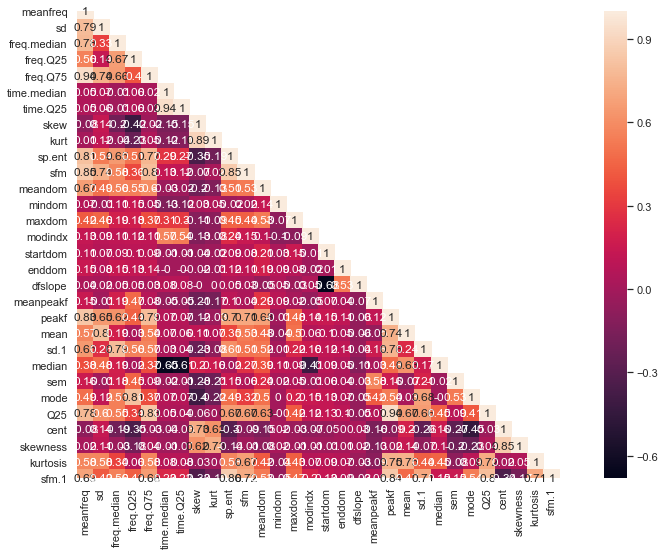

In [12]:
#corelation matrix.
cor_mat= encoded_data.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(14, 8)
sns.heatmap(data=cor_mat.round(decimals=2), mask=mask, square=True, annot=True, cbar=True);

***
Добавляем дополнительных фич


In [13]:
encoded_data['meanfreq'] = encoded_data['meanfreq'].apply(lambda x: x*20)
encoded_data['median']= encoded_data['meanfreq'] + encoded_data['mode']
encoded_data['median'] = encoded_data['median'].apply(lambda x: x/3)
encoded_data['pear_skew'] = encoded_data['mean'] - encoded_data['mode']
encoded_data['pear_skew'] = encoded_data['pear_skew'] / encoded_data['sd']
encoded_data['pear_skew'].replace([np.inf, -np.inf], 0, inplace=True)
encoded_data.drop(['kurt','mindom','maxdom'],axis=1,inplace=True)
columns_for_model = encoded_data.columns

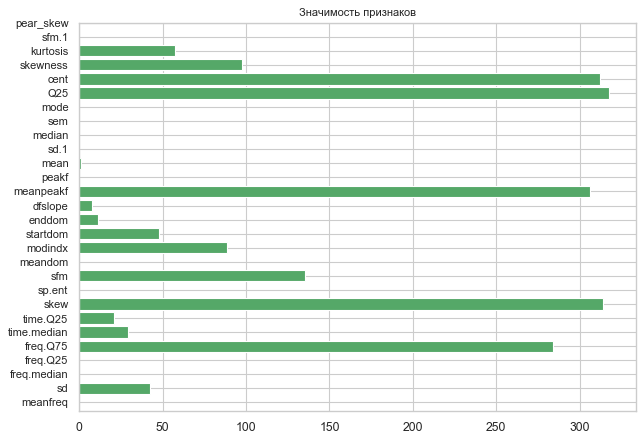

In [14]:
# определяем значимость фич по кореляции с зависимым показателем
selector = SelectKBest(f_classif, k=5)
selector.fit(encoded_data, train_df['gender'])

scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(8, 6), dpi=80)
plt.barh(range(len(encoded_data.columns)), scores, color='g')
plt.yticks(range(len(encoded_data.columns)), encoded_data.columns, rotation=0, fontsize=10)
plt.title('Значимость признаков', fontsize=10)
plt.show()

Проведем одномерный анализ основных фич. Кроме построения boxplot и гистограммы приводится количество значений показателя, которые останутся, если удалить выбросы (рассчитаны как величины превышающие Q25 - 1.5(Q75 - Q25) и Q25 - 1.5(Q75 - Q25)).

In [15]:
size = len(encoded_data)

def calc_limits(feature):
    q1, q3  = encoded_data[feature].quantile([0.25, 0.75])
    iqr = q3 - q1
    rang = 1.5* iqr
    return (q1-rang, q3+rang)
 
def plot(feature):
    fig, axes = plt.subplots(1, 2)
    sns.boxplot(data=encoded_data, x=feature, ax=axes[0])
    sns.distplot(a=encoded_data[feature], ax=axes[1], color='#ff4125')
    fig.set_size_inches(12, 4)
    
    lower,upper = calc_limits(feature)
    l = [encoded_data[feature] for i in encoded_data[feature] if i > lower and i < upper] 
    print("Количество строк с даными, которое останется если удалить выбросы:",len(
        l), " или", round(len(l)/size*100, ndigits=2),'%.')

Количество строк с даными, которое останется если удалить выбросы: 18460  или 98.53 %.


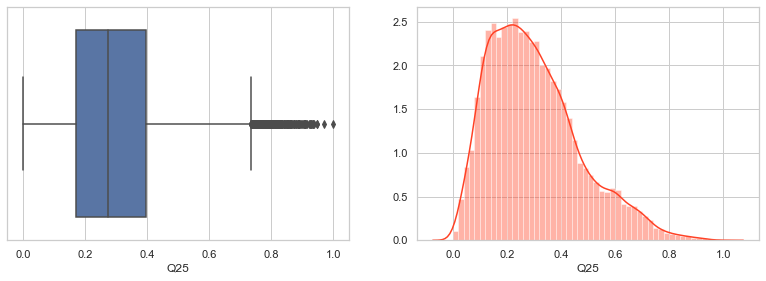

In [16]:
plot('Q25')

Количество строк с даными, которое останется если удалить выбросы: 18115  или 96.69 %.


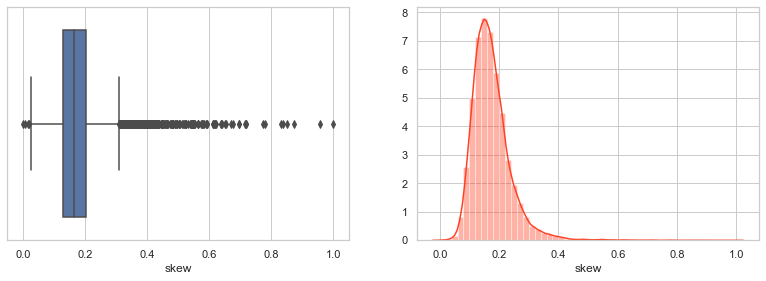

In [17]:
plot('skew')

Количество строк с даными, которое останется если удалить выбросы: 18319  или 97.78 %.


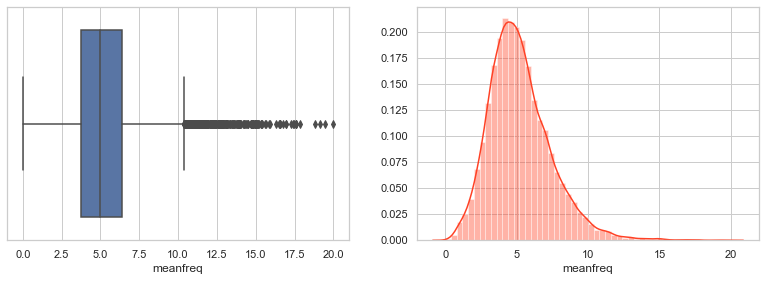

In [18]:
plot('meanfreq')

Анализ фич по отношению к разным значениям целевого значения. Для анализа временно добавим целевое значение в выборку.

In [19]:
encoded_data['gender'] = train_df['gender']

def plot_against_target(feature):
    sns.factorplot(data=encoded_data, y=feature, x='gender', kind='box')
    fig=plt.gcf()
    fig.set_size_inches(7,7)

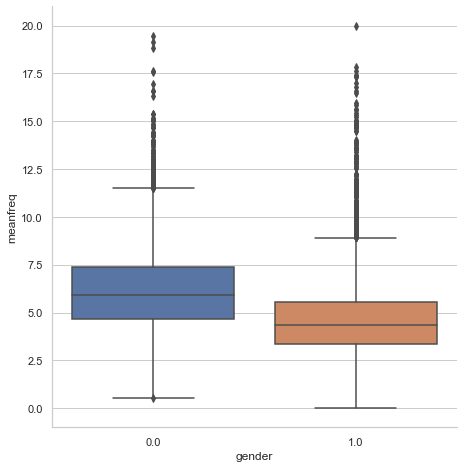

In [20]:
plot_against_target('meanfreq') # 0 для женщин, 1 для мужчин
# Boxplot показывает, что женщины имеют более высокую среднюю частоту голоса чем мужчины.

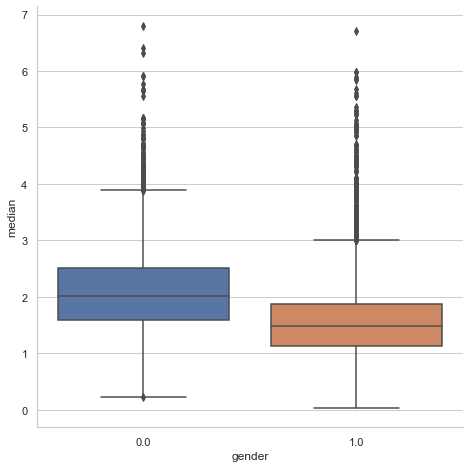

In [21]:
plot_against_target('median')

***
Считаем модель 

In [22]:
del encoded_data['gender']
X = np.array(encoded_data[encoded_data._get_numeric_data().columns])
X

array([[2.91377682, 0.50630853, 0.08153493, ..., 0.44912815, 0.6812287 ,
        0.73692114],
       [5.14272374, 0.59470744, 0.07277611, ..., 0.50223027, 0.61617519,
        0.80810678],
       [5.09918887, 0.61178034, 0.06686786, ..., 0.39544947, 0.5803018 ,
        0.90078151],
       ...,
       [6.52619924, 0.54176126, 0.18014   , ..., 0.49264975, 0.7386586 ,
        0.60154042],
       [8.03053292, 0.58516944, 0.22647102, ..., 0.5618019 , 0.80535264,
        0.60612296],
       [4.86037296, 0.59472042, 0.0907409 , ..., 0.20054968, 0.75223329,
        0.4502594 ]])

In [23]:
y = train_df['gender'].as_matrix()
pd.Series(y).value_counts() # проверяем балансировку данных

1.0    11032
0.0     7703
dtype: int64

In [24]:
# проводим балансировку данных
ids = np.argwhere(y == 1).flatten()
ids = shuffle(ids, random_state = 42)
ids = ids[len(np.argwhere(y == 0).flatten()):]
print('Данные сбалансированы -', len(
    np.argwhere(y == 1).flatten()) - len(ids) == len(np.argwhere(y == 0).flatten()))

X = np.delete(X, ids, 0)
y = np.delete(y, ids, 0)
# отобразим итоговый размер признаков датасета
print(X.shape, y.shape)
pd.Series(y).value_counts()

Данные сбалансированы - True
(15406, 28) (15406,)


0.0    7703
1.0    7703
dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

models=[LogisticRegression(), LinearSVC(), SVC(kernel='rbf'), KNeighborsClassifier(), RandomForestClassifier(),
        DecisionTreeClassifier(), GradientBoostingClassifier(), GaussianNB()]
model_names=['LogisticRegression', 'LinearSVM', 'rbfSVM', 'KNearestNeighbors', 'RandomForestClassifier', 'DecisionTree',
             'GradientBoostingClassifier', 'GaussianNB']

acc=[]
d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(pred, y_test))

acc_frame = pd.DataFrame({'Modelling Algo':model_names, 'Accuracy':acc})
acc_frame

,Modelling Algo,Accuracy
0,LogisticRegression,0.910861
1,LinearSVM,0.921679
2,rbfSVM,0.895716
3,KNearestNeighbors,0.877975
4,RandomForestClassifier,0.945478
5,DecisionTree,0.920814
6,GradientBoostingClassifier,0.954998
7,GaussianNB,0.802683


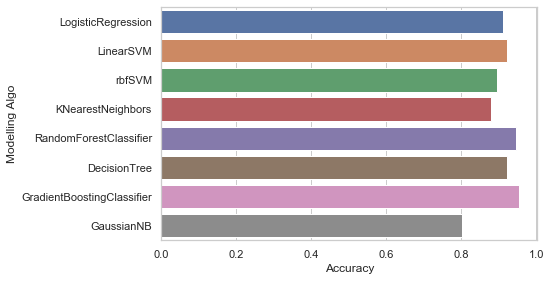

In [26]:
sns.barplot(y='Modelling Algo', x='Accuracy', data=acc_frame);

***
Визуализируем модель на решающих деревьях глубиной 3 для выявления наиболее значимых параметров модели, по которым можно разделить выборку на мужчин и женщин.

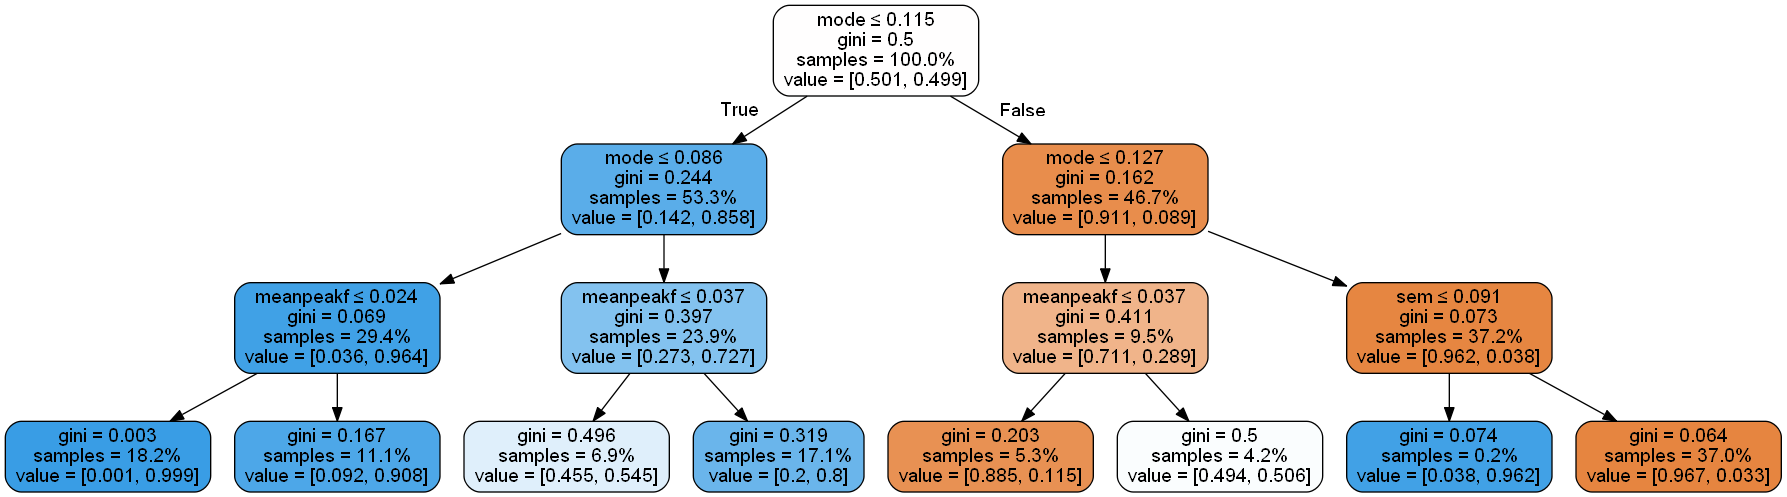

In [27]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

def plot_tree(dtree, features):
    from io import StringIO  
    from IPython.display import Image, display  
    from sklearn.tree import export_graphviz
    import pydotplus
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names=features, proportion=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png())
    display(img)
    
plot_tree(model, encoded_data.columns)

Наиболее значимыми показателями для разделения выборки на мужчин и женщин являются показатели "mode" и "meanpearf".
***

Тюнинг парамтеров модели с использованием GridSearchCV

In [28]:
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)

In [29]:
%%time
alg_frst_model = RandomForestClassifier(random_state=42)
alg_frst_params = [{
    "n_estimators": [250, 350, 400, 450],
    "min_samples_split": [4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 6]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_frst_grid.fit(X, y)
alg_frst_best = alg_frst_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 43.9min finished


Accuracy (random forest auto): 0.9487861871997922 with params {'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
Wall time: 44min 41s


In [30]:
%%time
ald_gb_model = GradientBoostingClassifier()
ald_gb_params = [
    {"n_estimators": [200, 300, 500],
     "max_depth": [1, 2, 4],
     "learning_rate": [0.01, 0.05, 0.1]}
]
alg_gb_grid = GridSearchCV(ald_gb_model, ald_gb_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_gb_grid.fit(X, y)
alg_gb_best = alg_gb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_gb_grid.best_score_, alg_gb_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  9.5min finished


Accuracy (xgboost auto): 0.9616383227314034 with params {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Wall time: 10min 27s


In [31]:
with open('alg_gb_best.pickle', 'wb') as f:
    pickle.dump(alg_gb_best, f)

#### 2.2.3. Обучение по определению возрастной группы<a id='2.2.3'></a>

twenties    6385
fifties     1318
Name: age_, dtype: int64

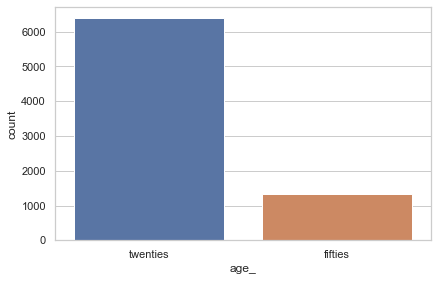

In [32]:
sns.countplot(data=train_df[train_df['gender']==0.0], x='age_'); # выделяем женскую группу
train_df[train_df['gender']==0.0]['age_'].value_counts()

twenties    7469
fourties    3084
thirties     438
teens         41
Name: age_, dtype: int64

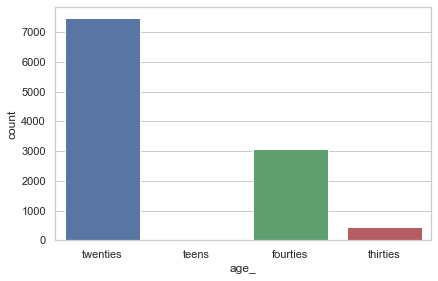

In [33]:
sns.countplot(data=train_df[train_df['gender']==1.0], x='age_'); # выделяем мужскую группу
train_df[train_df['gender']==1.0]['age_'].value_counts()

Данные по возрасту не сбалансированы, поэтому в связи со значительным перекосом данных делим весь дата сет на группы:
- старше 20
- младше 20

и провоим балансировку относительно меньшей группы

In [34]:
train_df['y_or_o'] = 0
train_df['y_or_o'] = train_df.apply(lambda x: 1 if x['age_'] == 'twenties' else 0, axis=1)
train_df.head(2)

,sound.files,meanfreq,sd,freq.median,freq.Q25,freq.Q75,freq.IQR,time.median,time.Q25,time.Q75,...,skewness,kurtosis,sfm.1,sh,path,age,gender,gender_,age_,y_or_o
0,common_voice_ru_18849003_0_0.wav,1.060095,1.523735,0.488977,0.177558,0.984591,0.807033,0.325766,0.244324,0.602667,...,40.704867,0.317205,0.895792,0.356125,common_voice_ru_18849003,4.0,1.0,male,twenties,1
1,common_voice_ru_18849004_1_0.wav,1.462032,1.702063,0.448176,0.286591,2.691898,2.405307,0.971034,0.372230,1.861149,...,79.844474,0.351285,0.881560,0.262055,common_voice_ru_18849004,4.0,1.0,male,twenties,1


In [35]:
encoded_data['gender'] = train_df['gender']
encoded_data['y_or_o'] = train_df['y_or_o']

train_df_f = encoded_data[encoded_data['gender']==0.0]
train_df_m = encoded_data[encoded_data['gender']==1.0]

***
Проводим расчет модели по определению возрастной группы для женщин.

In [36]:
# проводим балансировку данных для женщин
y_f = train_df_f['y_or_o'].as_matrix()

del train_df_f['gender']
del train_df_f['y_or_o']
X_f = np.array(train_df_f[train_df_f._get_numeric_data().columns])
scaler = StandardScaler()
scaler.fit(X)
X_f = scaler.transform(X)

pd.Series(y).value_counts() # проверяем балансировку данных

ids = np.argwhere(y == 1).flatten()
ids = shuffle(ids, random_state = 42)
ids = ids[len(np.argwhere(y == 0).flatten()):]
print('Данные сбалансированы -', len(
    np.argwhere(y == 1).flatten()) - len(ids) == len(np.argwhere(y == 0).flatten()))

X_f = np.delete(X, ids, 0)
y_f = np.delete(y, ids, 0)
# отобразим итоговый размер признаков датасета
print(X_f.shape, y_f.shape)
pd.Series(y_f).value_counts()

Данные сбалансированы - True
(15406, 28) (15406,)


0.0    7703
1.0    7703
dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.15, random_state=42)

models=[LogisticRegression(), LinearSVC(), SVC(kernel='rbf'), KNeighborsClassifier(), RandomForestClassifier(),
        DecisionTreeClassifier(), GradientBoostingClassifier(), GaussianNB()]
model_names=['LogisticRegression', 'LinearSVM', 'rbfSVM', 'KNearestNeighbors', 'RandomForestClassifier', 'DecisionTree',
             'GradientBoostingClassifier', 'GaussianNB']

acc=[]
d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(pred, y_test))

acc_frame = pd.DataFrame({'Modelling Algo':model_names, 'Accuracy':acc})
acc_frame

,Modelling Algo,Accuracy
0,LogisticRegression,0.910861
1,LinearSVM,0.921679
2,rbfSVM,0.895716
3,KNearestNeighbors,0.877975
4,RandomForestClassifier,0.947642
5,DecisionTree,0.913890
6,GradientBoostingClassifier,0.954998
7,GaussianNB,0.802683


In [38]:
# проводим обучение модели по алгоритму показавшему лучшие результаты
ald_gb_model_f = GradientBoostingClassifier()
ald_gb_params_f = [
    {"n_estimators": [500],
     "max_depth": [4],
     "learning_rate": [0.1]}
]
alg_gb_grid_f = GridSearchCV(ald_gb_model_f, ald_gb_params_f, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_gb_grid_f.fit(X_f, y_f)
alg_gb_best_f = alg_gb_grid_f.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_gb_grid_f.best_score_, alg_gb_grid_f.best_params_))

# сохраняем обученную модель для женщин
with open('alg_gb_best_f.pickle', 'wb') as f:
    pickle.dump(alg_gb_best_f, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   56.6s finished


Accuracy (xgboost auto): 0.9624821498117616 with params {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


***
Проводим расчет модели по определению возрастной группы для мужчин.

In [39]:
# проводим балансировку данных для мужчин
y_m = train_df_m['y_or_o'].as_matrix()

del train_df_m['gender']
del train_df_m['y_or_o']
X_m = np.array(train_df_m[train_df_m._get_numeric_data().columns])
scaler = StandardScaler()
scaler.fit(X)
X_m = scaler.transform(X)

pd.Series(y).value_counts() # проверяем балансировку данных

ids = np.argwhere(y == 1).flatten()
ids = shuffle(ids, random_state = 42)
ids = ids[len(np.argwhere(y == 0).flatten()):]
print('Данные сбалансированы -', len(
    np.argwhere(y == 1).flatten()) - len(ids) == len(np.argwhere(y == 0).flatten()))

X_m = np.delete(X, ids, 0)
y_m = np.delete(y, ids, 0)
# отобразим итоговый размер признаков датасета
print(X_m.shape, y_m.shape)
pd.Series(y_m).value_counts()

Данные сбалансированы - True
(15406, 28) (15406,)


0.0    7703
1.0    7703
dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_m, y_m, test_size=0.15, random_state=42)

models=[LogisticRegression(), LinearSVC(), SVC(kernel='rbf'), KNeighborsClassifier(), RandomForestClassifier(),
        DecisionTreeClassifier(), GradientBoostingClassifier(), GaussianNB()]
model_names=['LogisticRegression', 'LinearSVM', 'rbfSVM', 'KNearestNeighbors', 'RandomForestClassifier', 'DecisionTree',
             'GradientBoostingClassifier', 'GaussianNB']

acc=[]
d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(pred, y_test))

acc_frame = pd.DataFrame({'Modelling Algo':model_names, 'Accuracy':acc})
acc_frame

,Modelling Algo,Accuracy
0,LogisticRegression,0.910861
1,LinearSVM,0.921679
2,rbfSVM,0.895716
3,KNearestNeighbors,0.877975
4,RandomForestClassifier,0.947209
5,DecisionTree,0.920381
6,GradientBoostingClassifier,0.954998
7,GaussianNB,0.802683


In [41]:
# проводим обучение модели по алгоритму показавшему лучшие результаты
ald_gb_model_m = GradientBoostingClassifier()
ald_gb_params_m = [
    {"n_estimators": [500],
     "max_depth": [4],
     "learning_rate": [0.1]}
]
alg_gb_grid_m = GridSearchCV(ald_gb_model_m, ald_gb_params_m, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_gb_grid_m.fit(X_m, y_m)
alg_gb_best_m = alg_gb_grid_m.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_gb_grid_m.best_score_, alg_gb_grid_m.best_params_))

# cохраняем обученную модель.
with open('alg_gb_best_m.pickle', 'wb') as f:
    pickle.dump(alg_gb_best_m, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.9s finished


Accuracy (xgboost auto): 0.9630663377904712 with params {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


### 2.3. Определение пола и возрастной группы участников диалога<a id='2.3'></a>
[home](#0)

In [42]:
# проводим определение аудиохарактеристик файлов диалога разбитого по участникам на стадии 2.1
os.chdir(owd)
os.remove(os.getcwd() + '\\data\\data.csv')
path = os.getcwd() + '\\data\\chunks\\' # путь до аудиофайлов 
temp =  '\\data\\' # путь для сохранения csv с аудиопоказателями для определения пола 
path2script = 'C:/R/spectr.R' # путь до скрипта R - расположение скрипта должно быть прописано в path системы
spec = spec_r.Spec(path, temp, path2script)
spec.spec()

chunk-000.wav
chunk-001.wav
chunk-002.wav
chunk-003.wav
chunk-004.wav
chunk-005.wav
chunk-006.wav


In [43]:
# из датасета после обработки скрипитом R считываем данные с наименованием айдиофайла и аудиохарактеристиками
os.chdir(owd)
names_df = pd.read_csv('./data/tmpcsv/name.csv') # считываем наименования колонок с данными
predict_df = pd.read_csv('./data/data.csv', names=names_df.columns)
del predict_df['prec']
del predict_df['selec']
del predict_df['duration']
predict_df['path'] = all_df['sound.files'].apply(lambda x: x[:24])

encoded_data_, encoders = number_encode_features(predict_df)

scaler = MinMaxScaler()
encoded_data_[encoded_data_.columns] = scaler.fit_transform(encoded_data_[encoded_data_.columns])

encoded_data_['meanfreq'] = encoded_data_['meanfreq'].apply(lambda x: x*20)
encoded_data_['median']= encoded_data_['meanfreq'] + encoded_data['mode']
encoded_data_['median'] = encoded_data_['median'].apply(lambda x: x/3)
encoded_data_['pear_skew'] = encoded_data_['mean'] - encoded_data['mode']
encoded_data_['pear_skew'] = encoded_data_['pear_skew'] / encoded_data['sd']
encoded_data_['pear_skew'].replace([np.inf, -np.inf], 0, inplace=True)
encoded_data_.drop(['kurt','mindom','maxdom'],axis=1,inplace=True)
encoded_data_ = encoded_data_[columns_for_model]
X_pred = np.array(encoded_data_[encoded_data_._get_numeric_data().columns])

# загружаем сохраненную обученную модель
with open('alg_gb_best.pickle', 'rb') as f:
    alg_gb_best = pickle.load(f)
    
# загружаем сохраненную обученную модель для женщин
with open('alg_gb_best_f.pickle', 'rb') as f:
    alg_gb_best_m = pickle.load(f)

# загружаем сохраненную обученную модель мужчин
with open('alg_gb_best_m.pickle', 'rb') as f:
    alg_gb_best_m = pickle.load(f)

y_pred = alg_gb_best.predict(X_pred)

По полученной на стадии диаризация разбивке аудио файла диалога `dialog_lable` ( список вида [0, 0, 0, 0, 1, 0, 1], где 1 и 0 это разные участники диалога) определяем пол и возрастную группу участников диалога.
голосованием по количеству признаков - пол возрастная группа для каждого участника диалога.

In [44]:
predict_age = {'[1.]': 'до тридцати лет.', '[0.]': 'старше тридцати лет.'}
_person = {0: [[], []], 1: [[], []]}
for num, gender in enumerate(y_pred):
    if gender == 1:
        _person[dialog_lable[num]][0].append(gender)
        _person[dialog_lable[num]][1].append(predict_age[str(alg_gb_best_m.predict(X_pred[[num]]))])
    else:
        _person[dialog_lable[num]][0].append(gender)
        _person[dialog_lable[num]][1].append(predict_age[str(alg_gb_best_f.predict(X_pred[[num]]))])
print('Первый участник диалога,', 'мужчина' if max(_person[0][0])==1 else 'женщина', max(_person[0][1]))
print('Второй участник диалога,', 'мужчина' if max(_person[1][0])==1 else 'женщина', max(_person[1][1]))

Первый участник диалога, мужчина старше тридцати лет.
Второй участник диалога, мужчина старше тридцати лет.


[home](#0)